In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  # Important for scaling time series data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit


In [17]:
columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

AAPL_prices = pd.read_csv("../data/raw/yf_prices/AAPL.csv")
AMZN_prices = pd.read_csv("../data/raw/yf_prices/AMZN.csv")
BA_prices = pd.read_csv("../data/raw/yf_prices/BA.csv")
CAT_prices = pd.read_csv("../data/raw/yf_prices/CAT.csv")
CVX_prices = pd.read_csv("../data/raw/yf_prices/CVX.csv")
GS_prices = pd.read_csv("../data/raw/yf_prices/GS.csv")
JNJ_prices = pd.read_csv("../data/raw/yf_prices/JNJ.csv")
JPM_prices = pd.read_csv("../data/raw/yf_prices/JPM.csv")
MSFT_prices = pd.read_csv("../data/raw/yf_prices/MSFT.csv")
NEE_prices = pd.read_csv("../data/raw/yf_prices/NEE.csv")
NVDA_prices = pd.read_csv("../data/raw/yf_prices/NVDA.csv")
PFE_prices = pd.read_csv("../data/raw/yf_prices/PFE.csv")
TSLA_prices = pd.read_csv("../data/raw/yf_prices/TSLA.csv")
XOM_prices = pd.read_csv("../data/raw/yf_prices/XOM.csv")

In [18]:
def clean_prices_df(df):
    df = df.copy()
    df.rename(columns={"Price": "Date"}, inplace=True)
    df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
    df = df.dropna(subset=["Close"]).reset_index(drop=True)
    for col in ["High", "Low", "Open", "Volume"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    return df

In [19]:
AAPL_prices = clean_prices_df(AAPL_prices)
AMZN_prices = clean_prices_df(AMZN_prices)
BA_prices = clean_prices_df(BA_prices)
CAT_prices = clean_prices_df(CAT_prices)
CVX_prices = clean_prices_df(CVX_prices)
GS_prices = clean_prices_df(GS_prices)
JNJ_prices = clean_prices_df(JNJ_prices)
JPM_prices = clean_prices_df(JPM_prices)
MSFT_prices = clean_prices_df(MSFT_prices)
NEE_prices = clean_prices_df(NEE_prices)
NVDA_prices = clean_prices_df(NVDA_prices)
PFE_prices = clean_prices_df(PFE_prices)
TSLA_prices = clean_prices_df(TSLA_prices)
XOM_prices = clean_prices_df(XOM_prices)

In [20]:
def feature_engineer_prices_df(df):
    df = df.copy()

    # --- Basic price change features ---
    df["Return_1d"] = df["Close"].pct_change()
    df["Return_7d"] = df["Close"].pct_change(7)

    # --- Moving averages ---
    df["MA_7"] = df["Close"].rolling(window=7).mean()
    df["MA_14"] = df["Close"].rolling(window=14).mean()
    df["MA_30"] = df["Close"].rolling(window=30).mean()

    # --- Volatility ---
    df["Volatility_7d"] = df["Return_1d"].rolling(window=7).std()
    df["Volatility_14d"] = df["Return_1d"].rolling(window=14).std()

    # --- Volume features ---
    df["Volume_MA_7"] = df["Volume"].rolling(window=7).mean()
    df["Volume_Change_1d"] = df["Volume"].pct_change()

    # --- Lag features (previous close prices) ---
    df["Close_Lag_1"] = df["Close"].shift(1)
    df["Close_Lag_2"] = df["Close"].shift(2)
    df["Close_Lag_3"] = df["Close"].shift(3)
    df["Close_Lag_5"] = df["Close"].shift(5)
    df["Close_Lag_7"] = df["Close"].shift(7)
    df["Close_Lag_14"] = df["Close"].shift(14)
    df["Close_Lag_21"] = df["Close"].shift(21)

    # --- RSI (Relative Strength Index) ---
    delta = df["Close"].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    df["RSI_14"] = 100 - (100 / (1 + rs))

    # --- MACD (Moving Average Convergence Divergence) ---
    # Fast and Slow Exponential Moving Averages
    df["EMA_12"] = df["Close"].ewm(span=12, adjust=False).mean()
    df["EMA_26"] = df["Close"].ewm(span=26, adjust=False).mean()

    # MACD Line
    df["MACD"] = df["EMA_12"] - df["EMA_26"]

    # Signal Line (9-day EMA of MACD)
    df["MACD_Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()

    # interaction features
    df["Price_vs_MA30"] = df["Close"] / df["MA_30"]
    df["Vol_x_Return"] = df["Volume_Change_1d"] * df["Return_1d"]

    # Bollinger Bands
    df["MA_20"] = df["Close"].rolling(window=20).mean()
    df["Std_Dev_20"] = df["Close"].rolling(window=20).std()
    df["Bollinger_Upper"] = df["MA_20"] + (2 * df["Std_Dev_20"])
    df["Bollinger_Lower"] = df["MA_20"] - (2 * df["Std_Dev_20"])
    df["Price_vs_Bollinger"] = (df["Close"] - df["MA_20"]) / (
        2 * df["Std_Dev_20"]
    )  # Normalize position within bands

    # date features
    df["DayOfWeek"] = df["Date"].dt.dayofweek
    df["Month"] = df["Date"].dt.month
    df["WeekOfYear"] = df["Date"].dt.isocalendar().week.astype(int)
    df["Year"] = df["Date"].dt.year

    # range features
    df["Price_Range_HL"] = df["High"] - df["Low"]
    df["Price_Change_OC"] = df["Close"] - df["Open"]

    # --- Drop very early rows that have NaNs due to rolling windows ---
    df = df.dropna().reset_index(drop=True)

    return df

In [21]:
def prepare_data(df, target_col="Close", target_days=7):
    df = df.copy()

    # Keep the 'Close' price from the day the prediction is made FROM
    df["Prediction_Base_Price"] = df[target_col].shift(target_days)  # Price at t-7

    # Define the target as 7-day percentage return
    df["Target_Return"] = (
        df[target_col].pct_change(periods=target_days).shift(-target_days)
    )

    # Drop rows where target or base price is NaN
    # Also drop rows where original Close is NaN just in case
    df = df.dropna(subset=["Target_Return", "Prediction_Base_Price", target_col])

    # Store dates for plotting
    dates = df["Date"]

    # Define features (X) and target (y)
    # Ensure Prediction_Base_Price is NOT included in features unless intended
    features_to_drop = ["Target_Return", target_col, "Date", "Prediction_Base_Price"]
    features = df.drop(columns=[col for col in features_to_drop if col in df.columns])
    target = df["Target_Return"]
    base_prices = df["Prediction_Base_Price"]  # Keep this separate

    # Split data
    (
        X_train,
        X_test,
        y_train,
        y_test,
        dates_train,
        dates_test,
        base_prices_train,
        base_prices_test,
    ) = train_test_split(
        features, target, dates, base_prices, test_size=0.2, shuffle=False
    )

    # Return split data including base prices for evaluation
    # We only need to return the test versions of dates and base_prices usually
    return X_train, X_test, y_train, y_test, dates_test, base_prices_test

In [23]:
df = clean_prices_df(AAPL_prices)
df = df.sort_values("Date")
df = df[["Date", "Close"]].dropna()

# Normalize the Close prices
scaler = MinMaxScaler()
df["Close_scaled"] = scaler.fit_transform(df[["Close"]])


In [24]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 30
data = df["Close_scaled"].values
X, y = create_sequences(data, window_size)

X = X.reshape((X.shape[0], X.shape[1], 1))


In [25]:
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")


/Users/ericquezada/Desktop/Machine Learning/stock-price-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0456 - val_loss: 0.0119
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - val_loss: 6.1273e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - val_loss: 6.5181e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - val_loss: 6.9379e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - val_loss: 5.3667e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017 - val_loss: 6.1631e-04
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - val_loss: 4.4347e-04
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - val_loss: 4.2376e-04
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014 - val_loss: 8.0472e-04
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 6.7524e-04
Epoch 12/50
25/25 ━━━━━━━━━━━━━━

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Test RMSE: 5.12


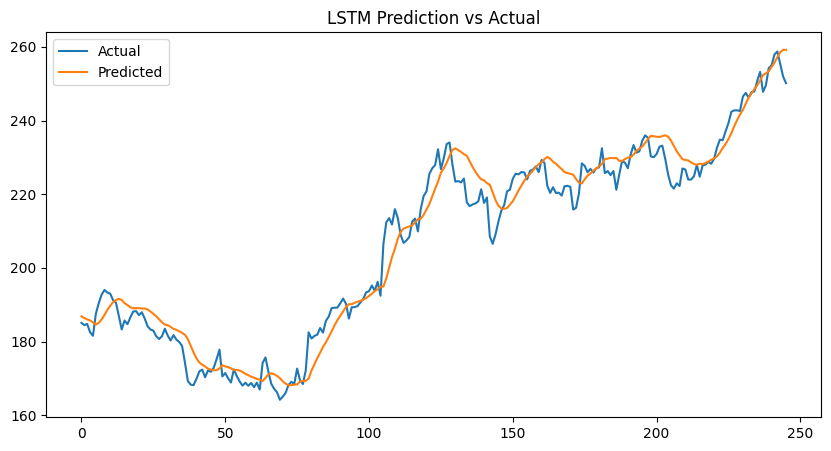

In [27]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Test RMSE: {rmse:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label="Actual")
plt.plot(y_pred_rescaled, label="Predicted")
plt.title("LSTM Prediction vs Actual")
plt.legend()
plt.show()
